In [1]:
pip install -q wandb lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 28.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("WANDB_API_KEY"))

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

True

In [3]:
import os, cv2, torch, gc
import numpy as np
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, Callback
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.rpn import AnchorGenerator
import random

In [4]:
from torchvision.models.detection.rpn import AnchorGenerator

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_transform = A.Compose([
    A.Resize(800, 800),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.CLAHE(p=0.5),
    A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(10, 32), hole_width_range=(10, 32), p=0.2),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'],min_visibility=0.1,min_area=1.0))

val_transform = A.Compose([
    A.Resize(800, 800),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [7]:
class PCBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        img_base = os.path.join(root_dir, 'images')
        ann_base = os.path.join(root_dir, 'Annotations')

        self.class_names = [
            'missing_hole', 'mouse_bite', 'open_circuit', 
            'short', 'spur', 'spurious_copper'
        ]
        self.label_map = {name: i + 1 for i, name in enumerate(self.class_names)}
        
        all_xmls = []
        for root, _, files in os.walk(ann_base):
            for f in files:
                if f.endswith('.xml'):
                    all_xmls.append(os.path.join(root, f))

        for xml_path in all_xmls:
            rel_path = os.path.relpath(xml_path, ann_base)
            img_path = os.path.join(img_base, rel_path).replace('.xml', '.JPG')
            
            if not os.path.exists(img_path):
                img_path = img_path.replace('.JPG', '.jpg')
            
            if os.path.exists(img_path):
                self.samples.append((img_path, xml_path))
        
    def __getitem__(self, idx):
        img_path, xml_path = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        tree = ET.parse(xml_path)
        boxes, labels = [], []
        for obj in tree.findall('object'):
            name = obj.find('name').text.lower().strip()
            label_id = self.label_map.get(name)
            if label_id is not None:
                labels.append(label_id)
                bbox = obj.find('bndbox')
                boxes.append([
                    float(bbox.find('xmin').text),
                    float(bbox.find('ymin').text),
                    float(bbox.find('xmax').text),
                    float(bbox.find('ymax').text)
                ])

        boxes = np.array(boxes, dtype=np.float32) if len(boxes) > 0 else np.zeros((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if len(labels) > 0 else np.zeros((0,), dtype=np.int64)

        if self.transform:
            sample = self.transform(image=image, bboxes=boxes, labels=labels)
            image = sample['image']
            boxes = torch.as_tensor(sample['bboxes'], dtype=torch.float32).reshape(-1, 4)
            labels = torch.as_tensor(sample['labels'], dtype=torch.int64)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float().div(255)
            boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        return image, target

    def __len__(self):
        return len(self.samples)

In [8]:
# ============================================================================
# CRITICAL FIXES FOR PCB DEFECT DETECTION
# ============================================================================

In [ ]:
class SubsetWithTransform(Dataset):
    """Fixed version with proper tensor handling"""
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img_path, xml_path = self.base_dataset.samples[actual_idx]
        
        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Parse annotations
        tree = ET.parse(xml_path)
        boxes, labels = [], []
        for obj in tree.findall('object'):
            name = obj.find('name').text.lower().strip()
            label_id = self.base_dataset.label_map.get(name)
            if label_id is not None:
                labels.append(label_id)
                bbox = obj.find('bndbox')
                boxes.append([
                    float(bbox.find('xmin').text),
                    float(bbox.find('ymin').text),
                    float(bbox.find('xmax').text),
                    float(bbox.find('ymax').text)
                ])
        
        boxes = np.array(boxes, dtype=np.float32) if len(boxes) > 0 else np.zeros((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if len(labels) > 0 else np.zeros((0,), dtype=np.int64)
        
        # Apply transform
        if self.transform:
            sample = self.transform(image=image, bboxes=boxes, labels=labels)
            image = sample['image']
            boxes = np.array(sample['bboxes'])  # Update boxes/labels from transform
            labels = np.array(sample['labels'])

        boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        labels_tensor = torch.as_tensor(labels, dtype=torch.int64)
        
        # Validation: Ensure boxes are valid
        if len(boxes_tensor) > 0:
            h, w = image.shape[-2:]
            boxes_tensor[:, [0, 2]] = boxes_tensor[:, [0, 2]].clamp(0, w)
            boxes_tensor[:, [1, 3]] = boxes_tensor[:, [1, 3]].clamp(0, h)
            
            # Keep only valid boxes
            keep = (boxes_tensor[:, 2] > boxes_tensor[:, 0]) & (boxes_tensor[:, 3] > boxes_tensor[:, 1])
            boxes_tensor = boxes_tensor[keep]
            labels_tensor = labels_tensor[keep]

        target = {
            "boxes": boxes_tensor,      
            "labels": labels_tensor,    
            "image_id": torch.tensor([actual_idx])
        }
        return image, target
    
    def __len__(self):
        return len(self.indices)

In [ ]:
def get_pcb_model(num_classes=7, use_pretrained=True):
    """Enhanced model with better anchor and NMS settings"""
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    
    # PCB defects are tiny. Use smaller anchors.
    anchor_sizes = ((4,), (8,), (16,), (32,), (64,)) 
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    model.rpn.anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    

    model.roi_heads.detections_per_img = 15 
    model.roi_heads.score_thresh = 0.4 
    model.roi_heads.nms_thresh = 0.3
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
class PCBInspector(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.class_names = [
            'background','missing_hole', 'mouse_bite', 
            'open_circuit', 'short', 'spur', 'spurious_copper'
        ]
        
        self.model = get_pcb_model(num_classes=len(self.class_names), use_pretrained=True)
        self.lr = lr
        
        self.map_metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)
        

        self.val_pred_counts = []
        self.val_gt_counts = []

    def training_step(self, batch, batch_idx):
        images, targets = batch
        
        for i, target in enumerate(targets):
            if len(target['boxes']) == 0:
                continue  # Skip empty targets
            assert target['boxes'].shape[1] == 4, f"Invalid box shape: {target['boxes'].shape}"
            assert (target['boxes'][:, 2] > target['boxes'][:, 0]).all(), "Invalid boxes in training"
            assert (target['boxes'][:, 3] > target['boxes'][:, 1]).all(), "Invalid boxes in training"
        
        loss_dict = self.model(list(images), targets)
        
        for loss_name, loss_value in loss_dict.items():
            self.log(f"train/{loss_name}", loss_value)

        losses = sum(loss for loss in loss_dict.values())
        self.log("train/total_loss", losses, prog_bar=True)
        return losses

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(list(images))


        filtered_outputs = []
        for out in outputs:
            # Only take the top 15 predictions that are actually confident
            mask = out['scores'] > 0.2
            filtered_outputs.append({
                'boxes': out['boxes'][mask][:15],
                'labels': out['labels'][mask][:15],
                'scores': out['scores'][mask][:15]
            })

        self.map_metric.update(filtered_outputs, targets)
    
        # Log only ONE image per epoch to save memory/recursion depth
        if batch_idx == 0:
            self._log_inspection_data(images[0], filtered_outputs[0], targets[0])
            
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def on_test_epoch_end(self):
        # This only runs ONCE at the very end
        metrics = self.map_metric.compute()
        self.log("test/mAP", metrics["map"].item())
        
        if self.trainer.is_global_zero:
            mAP_val = float(metrics['map'])
            print(f"DONE. Test mAP: {mAP_val:.4f}")
        
        self.map_metric.reset()
        
    
    def on_validation_epoch_end(self):
        metrics = self.map_metric.compute()
        self.log("val/mAP", metrics["map"], prog_bar=True)
        self.log("val/mAP_50", metrics["map_50"])  
        self.log("val/mAP_75", metrics["map_75"])  
        

        if len(self.val_pred_counts) > 0:
            avg_preds = np.mean(self.val_pred_counts)
            avg_gts = np.mean(self.val_gt_counts)
            self.log("debug/avg_pred_count", avg_preds)
            self.log("debug/avg_gt_count", avg_gts)
            print(f"\nEpoch {self.current_epoch}: Avg Predictions={avg_preds:.1f}, Avg GT={avg_gts:.1f}")
        
        # Log per-class metrics
        if "map_per_class" in metrics:
            for i, name in enumerate(self.class_names[1:]): 
                if i < metrics["map_per_class"].size(0):
                    class_score = metrics["map_per_class"][i]
                    self.log(f"val/mAP_{name}", class_score)

        self.map_metric.reset()
        self.val_pred_counts = []
        self.val_gt_counts = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.lr, 
            weight_decay=0.0001
        )
        
        total_steps = self.trainer.estimated_stepping_batches
        
        # Cosine annealing with warmup
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.lr,
            total_steps=total_steps,
            pct_start=0.1,  # 10% warmup
            anneal_strategy='cos'
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step"}
        }

    def _log_inspection_data(self, img, pred, target, key="val/visual_report"):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (std * img_np + mean).clip(0, 1) 

        class_id_to_name = {i: name for i, name in enumerate(self.class_names)}

        self.logger.experiment.log({
            key: wandb.Image(img_np, boxes={
                "predictions": {
                    "box_data": self._format_boxes(pred, is_pred=True),
                    "class_labels": class_id_to_name
                },
                "ground_truth": {
                    "box_data": self._format_boxes(target, is_pred=False),
                    "class_labels": class_id_to_name
                }
            })
        })

    def _format_boxes(self, output, is_pred=True):
        if len(output['boxes']) == 0:
            return []
            
        formatted_boxes = []
        # Ensure tensors are detached and moved to CPU before conversion
        boxes = output['boxes'].detach().cpu().numpy()
        labels = output['labels'].detach().cpu().numpy()
        
        if is_pred and 'scores' in output:
            scores = output['scores'].detach().cpu().numpy()
        else:
            scores = np.ones(len(labels))
            
        # Limit to top 20 boxes to prevent WandB recursion depth errors
        max_boxes = 20
        count = 0
    
        for box, label, score in zip(boxes, labels, scores):
            if count >= max_boxes:
                break
                
            # Increase threshold from 0.01 to 0.15 to filter out background noise
            if is_pred and score < 0.15:
                continue
                
            formatted_boxes.append({
                "position": {
                    "minX": float(box[0]), 
                    "minY": float(box[1]), 
                    "maxX": float(box[2]), 
                    "maxY": float(box[3])
                },
                "class_id": int(label), 
                "scores": {"confidence": float(score)},
                "domain": "pixel"
            })
            count += 1
    
        return formatted_boxes

In [12]:
def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(list(images))

        # Strict filtering for metric calculation
        filtered_outputs = []
        for out in outputs:
            # Only take the top 15 predictions that are actually confident
            mask = out['scores'] > 0.2
            filtered_outputs.append({
                'boxes': out['boxes'][mask][:15],
                'labels': out['labels'][mask][:15],
                'scores': out['scores'][mask][:15]
            })

        self.map_metric.update(filtered_outputs, targets)
    
        # Log only ONE image per epoch to save memory/recursion depth
        if batch_idx == 0:
            self._log_inspection_data(images[0], filtered_outputs[0], targets[0])

In [13]:
class MemoryCleanupCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        # Clears memory every 5 epochs to prevent cumulative fragmentation
        if (trainer.current_epoch + 1) % 5 == 0:
            torch.cuda.empty_cache() # Releases unused memory back to the GPU
            gc.collect()             # Force Python's garbage collector to clear CPU references

In [ ]:
def create_datasets_and_loaders():
    
    root_dir = "/kaggle/input/pcb-defects/PCB_DATASET"
    
    # Create base dataset (no transform)
    base_dataset = PCBDataset(root_dir, transform=None)
    print(f"Total valid image/annotation pairs found: {len(base_dataset)}")
    
    if len(base_dataset) == 0:
        raise RuntimeError("No images found. Check dataset path.")
    
    # Split indices
    dataset_size = len(base_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    indices = list(range(dataset_size))
    random.seed(42)
    random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]
    
    # Create datasets with different transforms
    train_ds = SubsetWithTransform(base_dataset, train_indices, transform=train_transform)
    val_ds = SubsetWithTransform(base_dataset, val_indices, transform=val_transform)
    test_ds = SubsetWithTransform(base_dataset, test_indices, transform=val_transform)
    
    print(f"Split complete: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")
    
    # Collate function
    def collate_fn(batch): 
        return tuple(zip(*batch))
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_ds, 
        batch_size=16, 
        shuffle=True, 
        collate_fn=collate_fn, 
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_ds, 
        batch_size=16, 
        shuffle=False, 
        collate_fn=collate_fn, 
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_ds, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [ ]:
import random
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision.ops import nms

def plot_pcb_random_results(model_path, test_ds, conf_thresh=0.45,sample_count=8):
    # 1. Load Model
    model = PCBInspector.load_from_checkpoint(model_path)
    model.to(device)
    model.eval()

    # 2. Setup Plot
    cols = 2
    rows = (sample_count + cols - 1) // cols
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))
    axes = axes.flatten()
    
    # 3. Pick 12 random indices from the test dataset
    indices = random.sample(range(len(test_ds)), sample_count)
    
    # ImageNet stats for denormalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    print(f"Generating report grid for 8 images...")

    for i, idx in enumerate(indices):
        image_tensor, target = test_ds[idx]
        
        # Inference
        with torch.no_grad():
            prediction = model.model([image_tensor.to(device)])[0]

        # Post-process (NMS)
        boxes = prediction['boxes']
        scores = prediction['scores']
        labels = prediction['labels']
        
        mask = scores > conf_thresh
        keep = nms(boxes[mask], scores[mask], iou_threshold=0.2)
        
        final_boxes = boxes[mask][keep].cpu().numpy()
        final_labels = labels[mask][keep].cpu().numpy()
        final_scores = scores[mask][keep].cpu().numpy()

        # Denormalize image for plotting
        img_plot = image_tensor.permute(1, 2, 0).cpu().numpy()
        img_plot = (img_plot * std + mean).clip(0, 1)
        
        ax = axes[i]
        ax.imshow(img_plot)
        
        # Color palette for defect types
        colors = plt.cm.get_cmap('rainbow', 7)

        for box, label, score in zip(final_boxes, final_labels, final_scores):
            name = model.class_names[label]
            c = colors(label)
            rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                                 fill=False, color=c, linewidth=2)
            ax.add_patch(rect)
            ax.text(box[0], box[1]-4, f"{name} {score:.2f}", 
                    fontsize=8, color='white', bbox=dict(facecolor=c, alpha=0.5, pad=0))

        ax.set_title(f"Test Image Index: {idx}", fontsize=12)
        ax.axis('off')

    for j in range(i+1,len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    # Convert the Matplotlib figure to a WandB Image object
    wandb.log({"Inference_Report_Grid": [wandb.Image(plt, caption="Final 8-Image Inference Grid")]})
    plt.savefig("pcb_report_grid.png", dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def train_pcb_model():
    """Complete training pipeline """
    
    # *** Create dataloaders  ***
    train_loader, val_loader, test_loader = create_datasets_and_loaders()
    
    # Close any existing wandb runs
    wandb.finish()
    
    # Initialize wandb
    wandb_logger = WandbLogger(
        project="PCB_Inspection", 
        name="run_critical_fixes_v2",
        log_model=False,
        reinit=True
    )
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath="pcb_checkpoints/", 
        filename="best-pcb-{epoch:02d}-{val_mAP:.3f}",
        monitor="val/mAP", 
        mode="max", 
        save_top_k=2,  # Keep top 2 models
        save_last=True 
    )
    
    early_stop = EarlyStopping(
        monitor="val/mAP",
        patience=15,  # Stop if no improvement for 15 epochs
        mode="max",
        verbose=True
    )
    
    # Initialize model
    model = PCBInspector(lr=0.0005)  # Lower initial LR
    
    # Trainer
    trainer = L.Trainer(
        max_epochs= 50,
        num_sanity_val_steps=2,  # Run 2 sanity validation steps
        logger=wandb_logger,
        accelerator="gpu",
        devices=1,
        log_every_n_steps=5,
        enable_progress_bar=True,
        gradient_clip_val=1.0,
        callbacks=[
            checkpoint_callback,
            early_stop,
            MemoryCleanupCallback()
        ],
        accumulate_grad_batches=2  # Effective batch size = 16 * 2 = 32
    )
    
    # Train
    print("Starting training with critical fixes...")
    trainer.fit(model, train_loader, val_loader)
    
    # Test
    print(f"\nTesting best model: {checkpoint_callback.best_model_path}")
    trainer.test(model, dataloaders=test_loader, ckpt_path="best")
    
    # Save results
    if trainer.global_rank == 0:
        # Get the path to the best model found during training
        best_model_path = checkpoint_callback.best_model_path
        test_ds = test_loader.dataset
        num_to_sample = min(len(test_ds),8)
        if best_model_path:
            print(f"Uploading best model to WandB: {best_model_path}")
            # Create a WandB Artifact for the best model
            artifact = wandb.Artifact('best_pcb_model', type='model')
            artifact.add_file(best_model_path)
            wandb.log_artifact(artifact)
            
        # Use .items() to create a clean dictionary and avoid recursion issues
        test_results = {k: v.item() if hasattr(v, 'item') else v for k, v in trainer.callback_metrics.items()}
        
        columns = ["Defect Class", "mAP Score"]
        summary_table = wandb.Table(columns=columns)
        
        for name in model.class_names[1:]:
            metric_key = f"test/mAP_{name}"
            if metric_key not in test_results:
                metric_key = f"val/mAP_{name}"
                
            score = test_results.get(metric_key, 0.0)
            summary_table.add_data(name, float(score))
        
        wandb.log({"Final_Class_Performance": summary_table})
        
        final_path = "pcb_checkpoints/final_model_weights.ckpt"
        trainer.save_checkpoint(final_path)
        
        print(f"\n{'='*60}")
        print(f"Training & Testing Complete!")
        # Check if best_model_score exists to avoid NoneType errors
        best_score = checkpoint_callback.best_model_score
        if best_score is not None:
            print(f"Best Validation mAP: {best_score:.4f}")
        print(f"Final weights saved to: {final_path}")
        print(f"{'='*60}")

        best_model_path = checkpoint_callback.best_model_path
        plot_pcb_random_results(best_model_path, test_ds,sample_count=num_to_sample)
        wandb.finish()

Total valid image/annotation pairs found: 693
Split complete: Train=485, Val=138, Test=70
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 212MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Starting training with critical fixes...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: setting up run 1071hetb
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in ./wandb/run-20260109_200520-1071hetb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run run_critical_fixes_v2
wandb: ⭐️ View project at https://wandb.ai/nakupatel-indus-university/PCB_Inspection
wandb: 🚀 View run at https://wandb.ai/nakupatel-indus-university/PCB_Inspection/runs/1071hetb
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ FasterRCNN           │ 41.3 M │ train │     0 │
│ 1 │ map_metric │ MeanAveragePrecision │      0 │ train │     0 │
└───┴────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 41.1 M                                                                                           
Non-trainable params: 222 K                                                                                        
Total params: 41.3 M                                                                                               
Total estimated model params size (MB): 165                                                                        
Modules in train mode: 190                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val/mAP improved. New best score: 0.000
Metric val/mAP improved by 0.007 >= min_delta = 0.0. New best score: 0.007
Metric val/mAP improved by 0.043 >= min_delta = 0.0. New best score: 0.050
Metric val/mAP improved by 0.070 >= min_delta = 0.0. New best score: 0.120
Metric val/mAP improved by 0.042 >= min_delta = 0.0. New best score: 0.161
Metric val/mAP improved by 0.066 >= min_delta = 0.0. New best score: 0.227
Metric val/mAP improved by 0.056 >= min_delta = 0.0. New best score: 0.284
Metric val/mAP improved by 0.033 >= min_delta = 0.0. New best score: 0.317
Metric val/mAP improved by 0.043 >= min_delta = 0.0. New best score: 0.360
Metric val/mAP improved by 0.005 >= min_delta = 0.0. New best score: 0.364
Metric val/mAP improved by 0.014 >= min_delta = 0.0. New best score: 0.379
Metric val/mAP improved by 0.021 >= min_delta = 0.0. New best score: 0.400
Metric val/mAP improved by 0.008 >= min_delta = 0.0. New best score: 0.407
Metric val/mAP improved by 0.017 >= min_delta = 0.0. 

Restoring states from the checkpoint path at /kaggle/working/pcb_checkpoints/best-pcb-epoch=46-val_mAP=0.000.ckpt



Testing best model: /kaggle/working/pcb_checkpoints/best-pcb-epoch=46-val_mAP=0.000.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /kaggle/working/pcb_checkpoints/best-pcb-epoch=46-val_mAP=0.000.ckpt


Output()

DONE. Test mAP: 0.4794

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mAP          │    0.47936099767684937    │
└───────────────────────────┴───────────────────────────┘

Uploading best model to WandB: /kaggle/working/pcb_checkpoints/best-pcb-epoch=46-val_mAP=0.000.ckpt


`weights_only` was not set, defaulting to `False`.



Training & Testing Complete!
Best Validation mAP: 0.4877
Final weights saved to: pcb_checkpoints/final_model_weights.ckpt
Generating report grid for 8 images...


/tmp/ipykernel_24/1193557524.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('rainbow', 7)


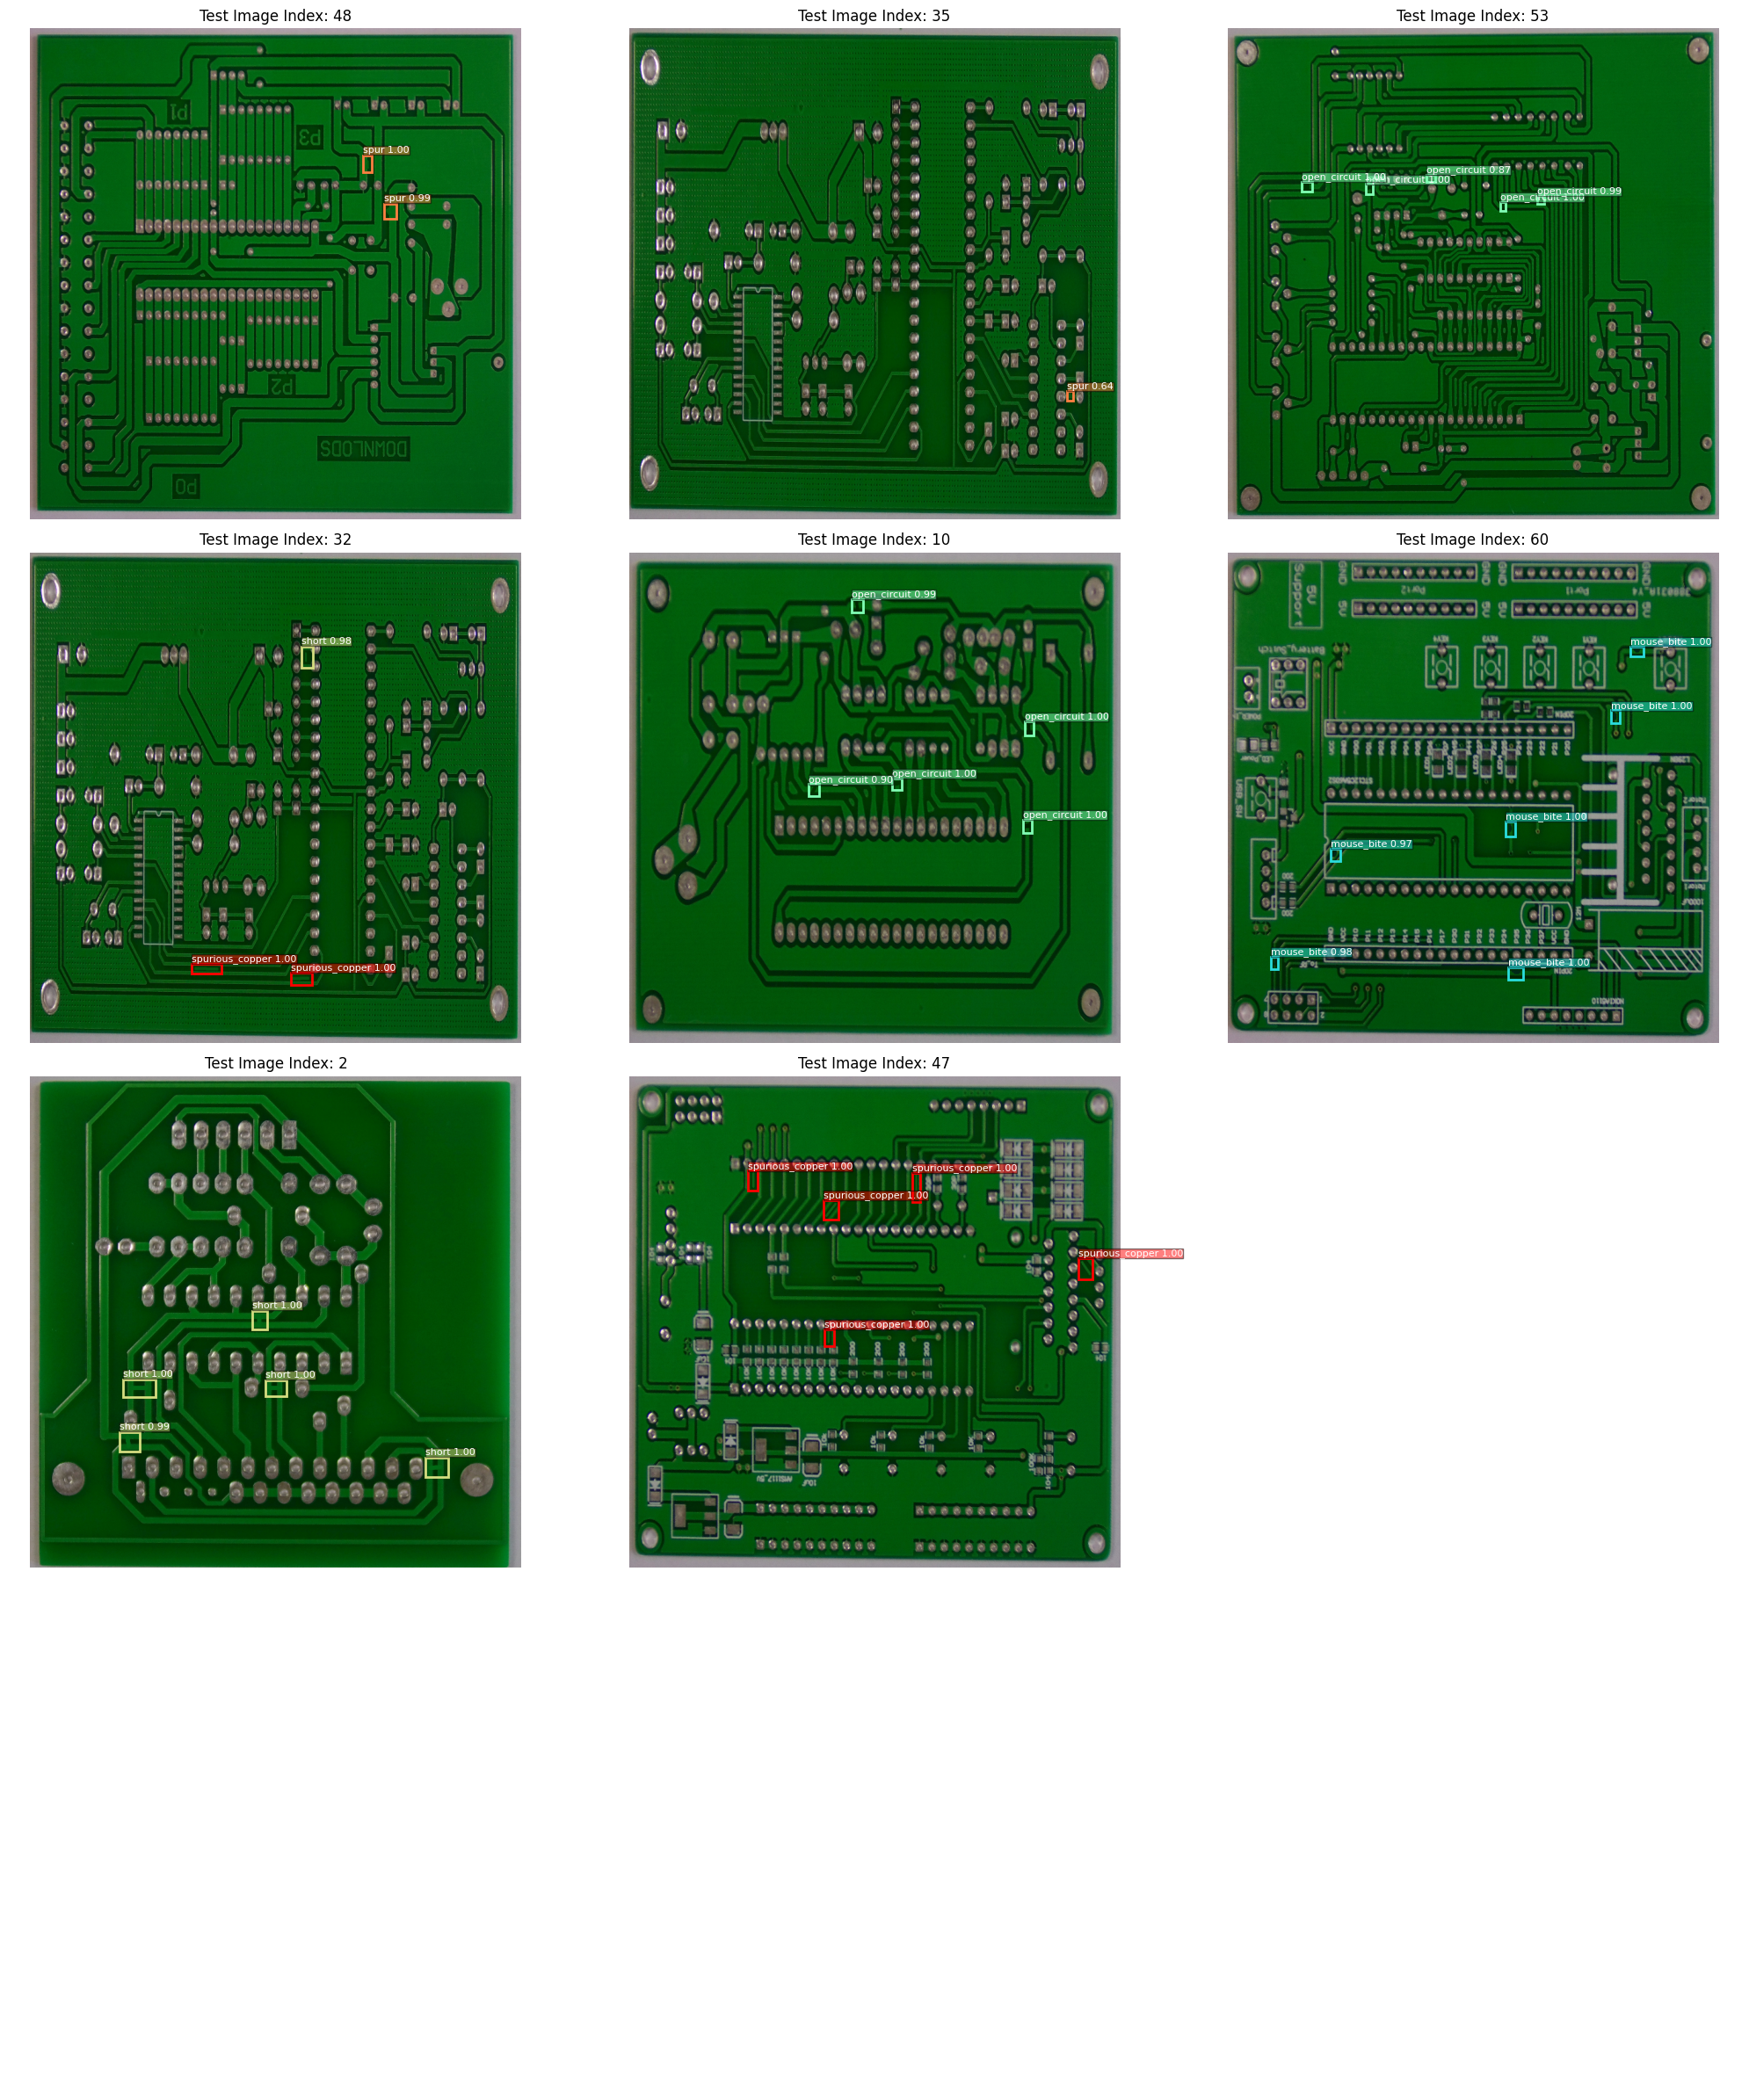

wandb: updating run metadata
wandb: uploading summary
wandb: 
wandb: Run history:
wandb:                  epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
wandb:               test/mAP ▁
wandb:     train/loss_box_reg ▂▁▁▁▂▂▃▆▄▆▅▅█▅▆▇▇█▇▆▇▇▆▆▆▅▆▆▅▅▆▅▅▅▅▅▄▅▅▆
wandb:  train/loss_classifier ▇▇▆█▅▆▆▄▃▄▃▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▂▁
wandb:  train/loss_objectness █▇▆▅▅▅▂▃▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train/loss_rpn_box_reg █▇█▆▆▄▄▃▃▄▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▁▂▁▁▁▁▂▁▂
wandb:       train/total_loss █▅▅▄▆▃▄▄▆▆▄▅▄▅▄▆▄▆▄▄▂▃▂▃▃▂▂▃▂▂▂▂▃▃▂▁▁▁▁▃
wandb:    trainer/global_step ▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
wandb:                val/mAP ▁▁▁▂▂▄▅▆▆▆▆▇▇▇▇▇▇▇██████████████████████
wandb:             val/mAP_50 ▁▁▁▂▂▅▆▇▇▇▇▇▇█▇█████████████████████████
wandb:                     +7 ...
wandb: 
wandb: Run summary:
wandb:                  epoch 50
wandb:               test/mAP 0.47936
wandb:     train/loss_box_reg 0.07963
wandb:  train/loss_classifier 0.01896
wandb:  train/loss_objectness 0.00026


In [17]:
# Run training
train_pcb_model()